# Dynamic Community Discovery

## Import libraries

In [1]:
import cdlib
import dynetx as dn
import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm, colors
from cdlib import algorithms, evaluation
from cdlib import TemporalClustering

set2 = sns.color_palette('Dark2')

## Import edgelist (one per quarter)

In [3]:
df_Q1 = pd.read_csv("../data_collection/data/df_Q1.csv")
df_Q2 = pd.read_csv("../data_collection/data/df_Q2.csv")
df_Q3 = pd.read_csv("../data_collection/data/df_Q3.csv")
df_Q4 = pd.read_csv("../data_collection/data/df_Q4.csv")


In [4]:
df_nickname_quarter = pd.concat([df_Q1,df_Q2,df_Q3,df_Q4])

In [5]:
df_nickname_quarter.to_csv("../data_collection/data/df_nickname_quarter.csv", index=False)

## Function

In [6]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[1], l[3], weight=int(float(l[5].rstrip('\n'))))
    return g

g = read_net_w("../data_collection/data/df_nickname_quarter.csv")
df_nickname = pd.read_csv("../data_collection/data/df_nickname_quarter.csv")


def plot_evolution(comm_polytree, comp = 0):
    g = comm_polytree.copy()
    #plotta un pezzo della rete

    nodes = list(nx.weakly_connected_components(comm_polytree))[comp]
    g.remove_nodes_from([n for n in comm_polytree.nodes() if n not in nodes])
   
    plt.figure(3,figsize=(10,10)) 
  
    node_colors = []
    label_dict = {}
    for community in g.nodes():
        label_dict[community] = str(community) + "\n" + str(len(tc.get_community(str(community))))
        if str(community) == "3_21":
            node_colors.append(set2[3])
        elif str(community) == "4_44":
            node_colors.append(set2[4])
        elif str(community) == "2_31":
            node_colors.append(set2[1])
        else:
            node_colors.append(set2[2])
    
    
    nx.draw(g, node_color=node_colors, with_labels=True, font_color='white', font_size = 15, node_size = 4000)
    plt.show()
    
def to_dictionary_to_plot(dict_com):
    df = pd.DataFrame.from_dict(dict_com, orient='index')
    df = df.transpose()
    df['len_community'] = [len(x) for x in df.iloc[:,0]]
    return df

def plot_dimensions(df, i):
    plt.figure(figsize=(11,7))
    df.len_community.head(20).plot(kind = 'bar', color = "darkslateblue")
    plt.xticks(rotation=0, ha='right')
    plt.title(f"Number of Twitter accounts in the 20 biggest communities ({i} quarter)")
    


## Creation of the agglomerative network

In [7]:
Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
g.remove_nodes_from([n for n in g if n not in set(Gcc[0])])

In [8]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 38444
Number of edges: 63611
Average degree:   3.3093


In [9]:
from random import sample

G = g.copy()
conn_comps = sorted(nx.connected_components(G), key=len, reverse=True) 
G.remove_nodes_from([n for n in G if n not in set(conn_comps[0])])

sampled_nodes = sample(G.nodes, 25000)  
G.remove_nodes_from([n for n in G if n not in set(sampled_nodes)])

conn_comps_sample = sorted(nx.connected_components(G), key=len, reverse=True)
G.remove_nodes_from([n for n in G if n not in set(conn_comps_sample[0])])

In [10]:
agglonet = nx.to_pandas_edgelist(G)

In [11]:
agglonet.drop_duplicates(keep='first', inplace=True, ignore_index=True)
len(agglonet)

19767

In [12]:
agglonet.to_csv('agglonet.csv', index=False)

In [13]:
agglonet

,source,target,weight
0,LMPD,minkslink,1
1,LMPD,kellyxbones,2
2,LMPD,az_canton,2
3,LMPD,butterflygone02,2
4,LMPD,nettiesnoggin,2
...,...,...,...
19762,momo69hrm,blar51,4
19763,momo69hrm,ErinLThomasPhD,4
19764,moveradicallyl1,chelebakes,4
19765,khutyo,USEmbassyNepal,4


## Louvain


In [15]:
g = nx.Graph()

Q1 = agglonet[agglonet["weight"]==1]
Q2 = agglonet[agglonet["weight"]==2]
Q3 = agglonet[agglonet["weight"]==3]
Q4 = agglonet[agglonet["weight"]==4]

quarter_TOT = [Q1, pd.concat([Q1,Q2]), 
               pd.concat([Q1,Q2, Q3]), pd.concat([Q1, Q2, Q3, Q4])]

In [16]:
tc = TemporalClustering()
t = 1


for df in quarter_TOT:
    g = nx.from_pandas_edgelist(df, source = "source", target = "target" )
    coms = algorithms.louvain(g)
    tc.add_clustering(coms, t)
    print(len(tc.get_clustering_at(t).communities))   
    t = t+1


126
350
235
72


In [17]:
tc.get_observation_ids()

[1, 2, 3, 4]

In [18]:
for i in tc.get_observation_ids():
    print(len(tc.get_clustering_at(i).communities))

126
350
235
72


In [19]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

[0.053852469135802467, 0.1422765738601824, 0.034967232247059894]

In [20]:
tc.has_explicit_match()

False

## cross temporal match

In [21]:
jaccard = lambda x, y: len(set(x) & set(y)) / len(set(x) | set(y))

In [22]:
matches = tc.community_matching(jaccard, two_sided=True)

In [23]:
f"Example of community match: {matches[1]}"

"Example of community match: ('1_1', '2_27', 0.45569620253164556)"

## Polytree

* we visualize the community lifecycle using the polytree structure

In [26]:
com_polytree = tc.lifecycle_polytree(jaccard, two_sided=False)
print(com_polytree)

* we remove all the nodes from the polytree that are not in the first weakly conn. comp. to reduce the computational time and improve the visualization

In [4]:
weak_comp = list(nx.weakly_connected_components(com_polytree))[0]
x = com_polytree.copy()
x.remove_nodes_from([n for n in com_polytree.nodes() if n not in weak_comp])
    


NameError: name 'com_polytree' is not defined

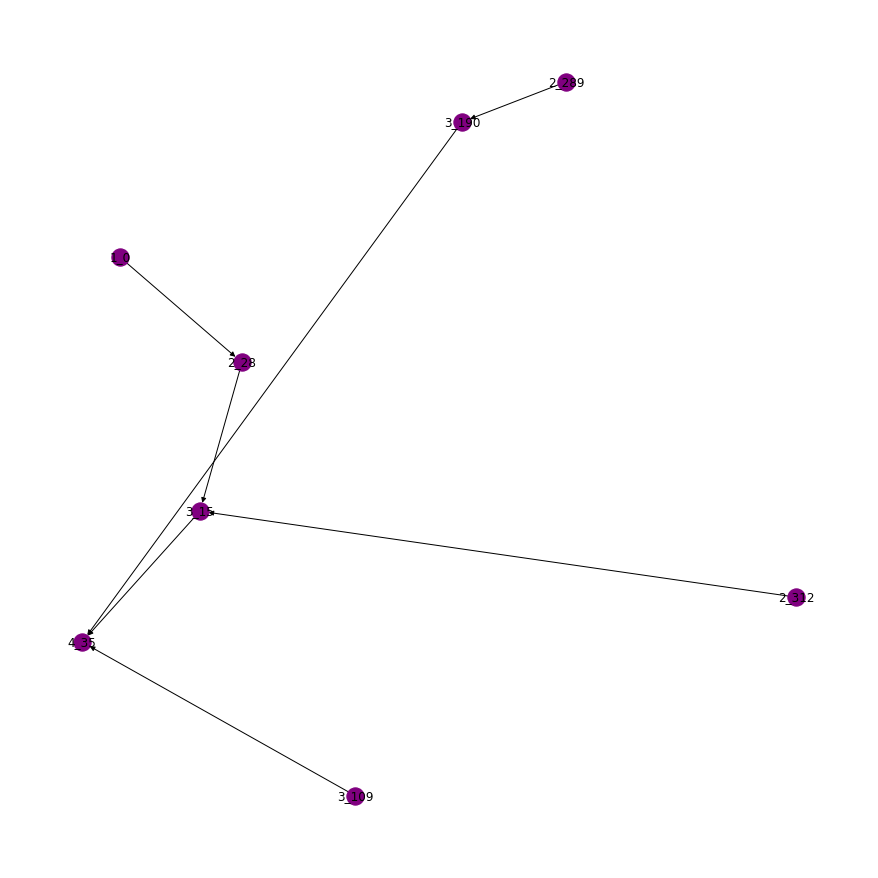

In [28]:
plt.figure(3,figsize=(12,12)) 
nx.draw(x, pos=nx.spring_layout(x), with_labels=True, node_color = "purple") 

In [430]:
nx.info(x)

'Name: \nType: DiGraph\nNumber of nodes: 5\nNumber of edges: 4\nAverage in degree:   0.8000\nAverage out degree:   0.8000'

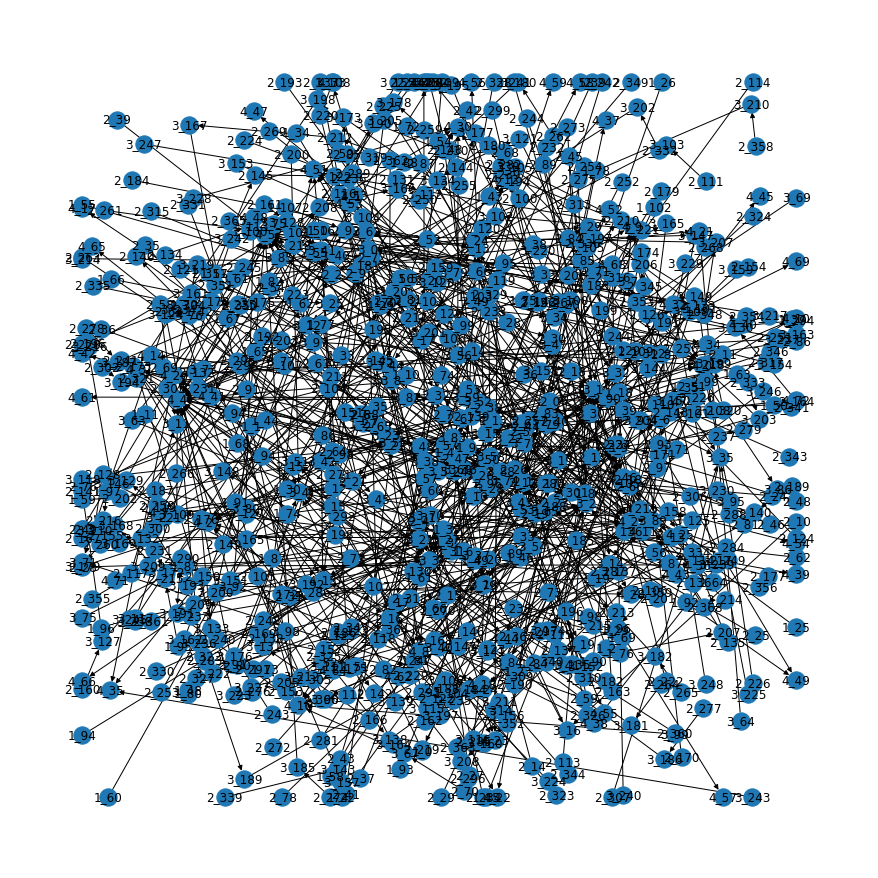

In [443]:
for nodes in nx.weakly_connected_components(com_polytree):
    sub =  com_polytree.subgraph(nodes)    
    plt.figure(3,figsize=(12,12)) 
    nx.draw(sub, pos=nx.spring_layout(sub), with_labels=True) 

In [444]:
tc.get_explicit_community_match()

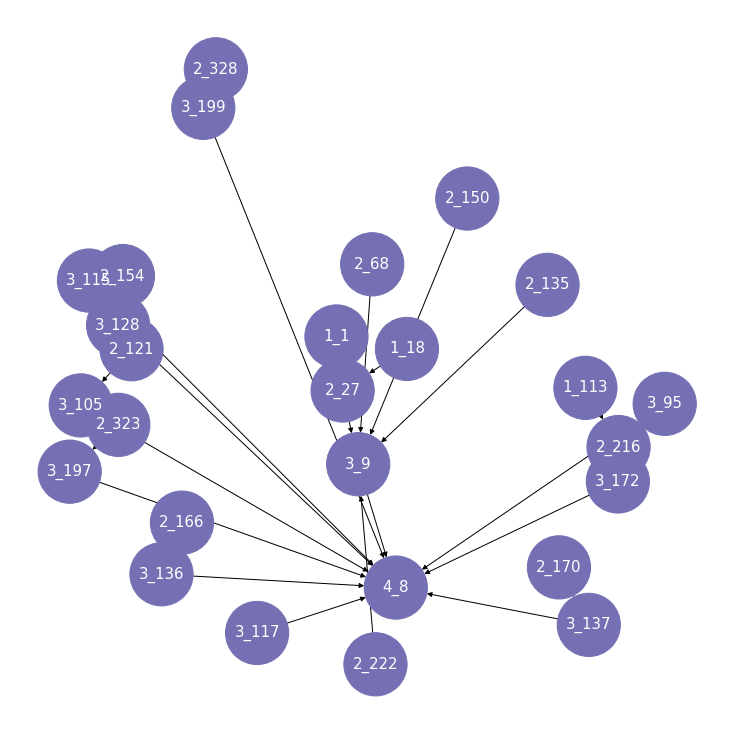

In [35]:
plot_evolution(com_polytree, comp = 1)

In [488]:
nx.write_gexf(x, "polytree_1.gexf")

In [361]:
list(nx.weakly_connected_components(com_polytree))

[{'1_0', '2_31', '3_48', '4_76'},
 {'1_1', '2_43', '3_76', '4_117'},
 {'1_2', '2_92', '3_97', '4_144'},
 {'1_3', '2_32', '3_15', '4_15'},
 {'1_4', '2_85', '3_98', '4_116'},
 {'1_5', '2_84', '3_124', '4_192'},
 {'1_6', '2_72', '3_71', '4_75'},
 {'1_7', '2_112', '3_160', '4_269'},
 {'1_8', '2_176', '3_245', '4_299'},
 {'1_9', '2_212', '3_300', '4_376'},
 {'1_10', '2_210', '3_343', '4_444'},
 {'1_11',
  '1_179',
  '1_187',
  '1_195',
  '1_28',
  '1_92',
  '1_95',
  '2_0',
  '2_306',
  '2_325',
  '2_628',
  '2_854',
  '2_855',
  '2_857',
  '2_867',
  '2_935',
  '2_958',
  '2_988',
  '3_0',
  '3_1454',
  '3_362',
  '3_811',
  '4_2'},
 {'1_12', '2_175', '3_271', '4_268'},
 {'1_13', '2_209', '3_298', '4_373'},
 {'1_14', '2_211', '3_299', '4_375'},
 {'1_15', '2_188', '3_404', '4_787'},
 {'1_16', '2_208', '3_295', '4_372'},
 {'1_17', '2_324', '3_479', '4_771'},
 {'1_18', '2_279', '3_614', '4_615'},
 {'1_19', '2_242', '3_355', '4_452'},
 {'1_20', '2_282', '3_484', '4_783'},
 {'1_21', '2_285', '3

In [362]:
tc.get_clustering_at(1).named_communities[matches[45][0]]

['herbsistah', 'LeslieMac', 'MikeElk']

In [363]:
json_res = tc.to_json()

### Community size through time

In [36]:
dict_com_1 = {}
dict_com_2 = {}
dict_com_3 = {}
dict_com_4 = {}
lista_dict = [dict_com_1, dict_com_2, dict_com_3, dict_com_4]

for i in tc.get_observation_ids():
    community = {}
    diz_comm = tc.get_clustering_at(i).named_communities
    for el in diz_comm:
        community[el] =  diz_comm[el]
    dizionario = lista_dict[i-1]    
    dizionario[i] = community


In [37]:
dict_com_1

{1: {'1_0': ['axios',
   'sharpephillip',
   'wisdom4peace',
   'healthybuttrfly',
   'cthagod',
   'ninaturner',
   'iamwandasykes',
   'SymoneDSanders',
   'Jaybefaunt',
   'krystalball',
   'joshokeefemusic',
   'BlackBernieBabe',
   'DaShaunLH',
   'Flying_Scot52',
   'Lawrence',
   'MSNBC',
   'MaryKayHenry',
   'RishiDesaiMD',
   'TheLastWord',
   'YouTube',
   'breakfastclubam',
   'esaagar',
   'jessicaramos',
   'jfusca29',
   'brwnswag',
   'heidiekmassey',
   'JasonOverstreet',
   'TheRoot',
   'ZerlinaMaxwell',
   'seankent',
   'mcdpeach',
   'thekc23',
   'evolvingmanlbv',
   'justgrateful',
   'scottladay',
   'mercyful626',
   'ViewFromWise',
   'umurbrogol',
   'BlackVotersMtr',
   'jetta1p',
   'ABC',
   'nikkiwatitdo',
   'melodyMcooper',
   'cjthefineartist',
   'AP',
   'steelworkers',
   'staceyhopkinsga',
   'TheBlackCaucus',
   'MattMurph24',
   'yasminv',
   'DavidCornDC',
   'detroithrbarbie',
   'realzachfluke1',
   'jenjavajunky',
   'vote_dem'],
  '1_1': ['

In [39]:
df_plot_Q1 = to_dictionary_to_plot(dict_com_1)
df_plot_Q2 = to_dictionary_to_plot(dict_com_2)
df_plot_Q3 = to_dictionary_to_plot(dict_com_3)
df_plot_Q4 = to_dictionary_to_plot(dict_com_4)

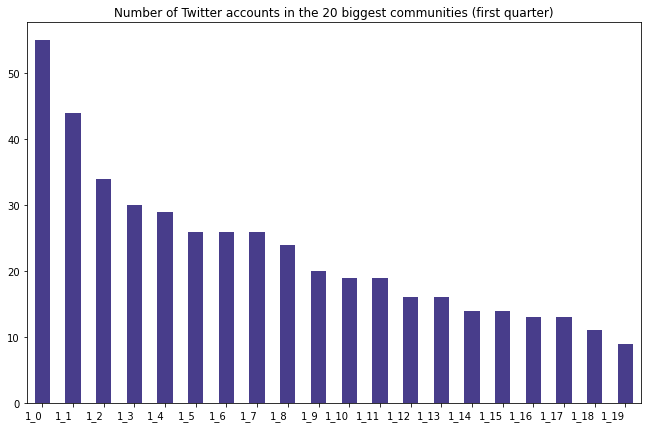

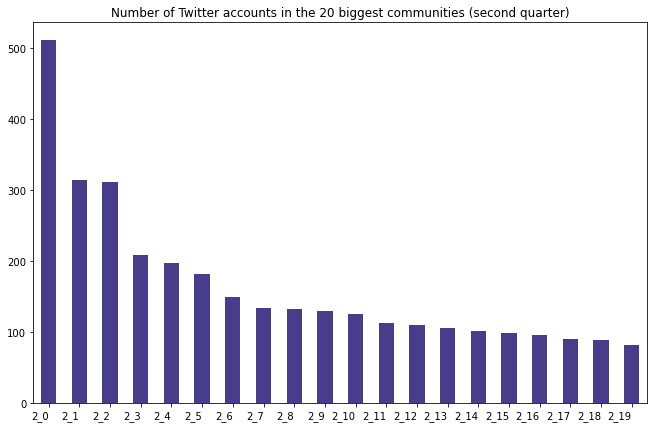

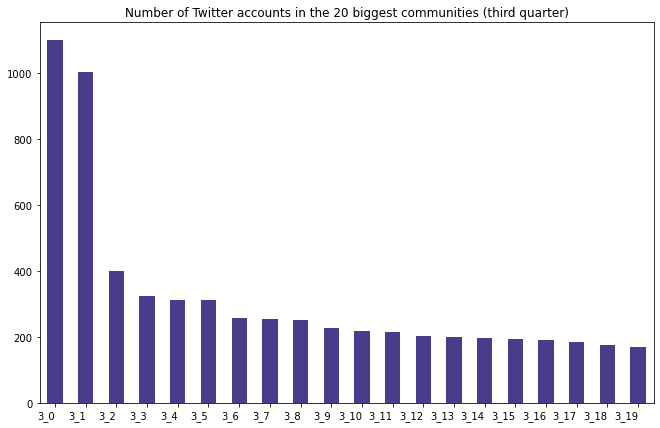

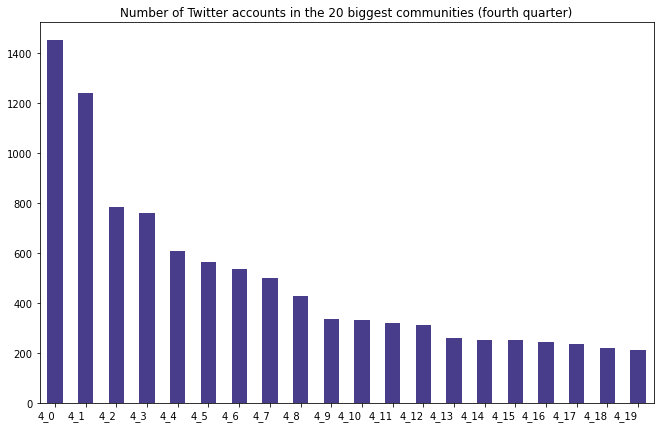

In [41]:
plot_dimensions(df_plot_Q1, "first")
plot_dimensions(df_plot_Q2, "second")
plot_dimensions(df_plot_Q3, "third")
plot_dimensions(df_plot_Q4, "fourth")

In [42]:
df_nick = df_nickname.copy()

# Temporal Trade-off: TILES

In [ ]:
tc = TemporalClustering()
i = 1

dg = dn.DynGraph()

for df in quarter_TOT:
    g = nx.from_pandas_edgelist(df, source = "source", target = "target" )
    dg.add_interactions_from(list(g.edges()), t=i)
    
    i = i+1


In [ ]:
for x in range(1,5):
    g = read_net(f"df_Q{x}.csv")


In [ ]:
tc = algorithms.tiles(dg, obs=1)

In [ ]:
type(coms)

cdlib.classes.node_clustering.NodeClustering

In [ ]:
tc.get_observation_ids()

[1, 2, 3, 4]

In [ ]:
type(tc.get_clustering_at(2))

cdlib.classes.named_clustering.NamedClustering

In [ ]:
tc.get_clustering_at(2).named_communities.keys()

dict_keys(['2_0', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '2_9', '2_10', '2_11', '2_12', '2_13', '2_14', '2_15', '2_16', '2_17', '2_18', '2_19', '2_20'])

In [ ]:
tc.has_explicit_match()

True

In [ ]:
match = tc.get_explicit_community_match()

In [ ]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

/home/erica/anaconda3/envs/cdlib/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/erica/anaconda3/envs/cdlib/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erica/anaconda3/envs/cdlib/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erica/anaconda3/envs/cdlib/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/erica/anaconda3/envs/cdlib/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity